# Utility functions to measure the effect on arbitrary data

In [1]:
%matplotlib notebook

In [2]:
import sep
import glob
import numpy as np
from scipy.stats import sigmaclip
from scipy.signal import convolve2d
from matplotlib import pyplot as plt


def subtract_background(data):
    """Subtract the background from data.
    
    We assume that we are working with a bias or dark frame, so we don't
    have to worry about detecting and masking out objects.
    """
    background = sep.Background(data)
    
    sub_data = data - background.back()
    
    return sub_data


def build_cosmic_mask(data):
    """
    Build a cosmic ray mask for a residual image.

    This is a very naive algorithm. We are running on residuals, so we cut
    anything that is 5 sigma high or low. We then mask by a couple pixels
    around the cut too to capture the tail.
    """
    target_nmad = nmad(data)
    start_mask = np.abs(data - np.median(data)) > 5. * target_nmad

    num_edge_pixels = 2
    mask = ~(convolve2d(
        start_mask,
        np.ones((2*num_edge_pixels+1, 2*num_edge_pixels+1)),
        mode='same'
    ).astype(bool))

    return mask


def clipped_mean(data):
    clip_data, min_clip, max_clip = sigmaclip(data)
    
    mean = np.mean(clip_data)
    mean_err = np.std(clip_data) / np.sqrt(len(clip_data) - 1)

    return mean, mean_err


def nmad(data, *args, **kwargs):
    return 1.4826 * np.median(
        np.abs(np.asarray(data) - np.median(data, *args, **kwargs)),
        *args, **kwargs
    )

_cache_num_ones = {}
def cached_num_binary_ones(x):
    try:
        return _cache_num_ones[x]
    except KeyError:
        num_ones = _num_binary_ones(x)
        _cache_num_ones[x] = num_ones
        return num_ones

def _num_binary_ones(x):
    return bin(x).count('1')

def calc_num_binary_ones(x):
    x = np.atleast_1d(x)
    out = np.zeros(x.shape)
    for i in range(len(x.flat)):
        out.flat[i] = cached_num_binary_ones(x.flat[i])
    
    return out


def calculate_mean_residual(data, offset, do_diff=True, residuals=None):
    """Calculate the mean residuals as a function of the value of a
    reference pixel.
    
    This will return a list of raw pixel values and the average residuals
    for pixels separated by "offset" from pixels with those values.
    
    If do_diff is True, we look at a difference between the offset in the left
    direction and the right direction to cancel out effects like pickup.
    Otherwise, we only look in the direction specified by offset.
    
    The sign of offset doesn't really matter if used in diff mode since the
    positive and negative offsets will be subtracted from each other. However,
    if do_diff is False then they do matter. I have not determined the
    readout direction on each instrument tested here, so a positive offset may
    or may not be in the readout direction.
    """
    if residuals is None:
        # If we weren't given residuals, just assume that the image is relatively
        # flat and do a local background subtraction.
        residuals = subtract_background(data.astype(float).copy())
    
    # We look at the difference in residuals from one side to the next.
    ref_1 = np.roll(data, offset)
    ref_2 = np.roll(data, -offset)
    
    # Generate a mask to filter out cosmic rays/bad pixels.
    mask = build_cosmic_mask(data)
    use_residuals = residuals[mask]
    use_ref_1 = ref_1[mask]
    use_ref_2 = ref_2[mask]

    # Figure out which range of pixel values to probe.
    min_values = np.percentile(data, 2)
    max_values = np.percentile(data, 98)
    pixel_values = np.arange(min_values, max_values+1)
    
    residual_means_1 = []
    residual_means_2 = []
    residual_errs_1 = []
    residual_errs_2 = []
    
    for pixel_value in pixel_values:
        cut_1 = use_ref_1 == pixel_value
        cut_2 = use_ref_2 == pixel_value
        
        # For each value that is found in at least 20 pixels we calculate a
        # clipped mean of the residuals and estimate an error on it.
        if np.sum(cut_1) > 20:
            mean_1, mean_err_1 = clipped_mean(use_residuals[cut_1])
        else:
            mean_1 = np.nan
            mean_err_1 = np.nan
        
        if np.sum(cut_2) > 20:
            mean_2, mean_err_2 = clipped_mean(use_residuals[cut_2])
        else:
            mean_2 = np.nan
            mean_err_2 = np.nan
        
        residual_means_1.append(mean_1)
        residual_means_2.append(mean_2)
        residual_errs_1.append(mean_err_1)
        residual_errs_2.append(mean_err_2)
        
    residual_means_1 = np.array(residual_means_1)
    residual_means_2 = np.array(residual_means_2)
    residual_errs_1 = np.array(residual_errs_1)
    residual_errs_2 = np.array(residual_errs_2)

    # Calculate the difference in residuals in each direction. This is what
    # we will look at to see if the binary offset effect is present since it
    # is relatively clean.
    if do_diff:
        residual_means = residual_means_1 - residual_means_2
        residual_errs = np.sqrt(residual_errs_1**2 + residual_errs_2**2)
    else:
        residual_means = residual_means_1
        residual_errs = residual_errs_1
    
    return pixel_values, residual_means, residual_errs

def setup_figure():
    #fig = plt.figure()
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5, 1], 'hspace': 0.})
    
    fig_parts = (fig, ax1, ax2)
    
    return fig_parts
    
    # fig.savefig(filename)

def plot_mean_residual(data, offset, label=None, do_diff=True,
                       residuals=None, fig_parts=None):
    """Plot the mean residuals calculated using calculate_mean_residual."""
    pixel_values, residual_means, residual_errs = \
        calculate_mean_residual(data, offset, do_diff=do_diff, residuals=residuals)
    
    if fig_parts is not None:
        fig = fig_parts[0]
        ax = fig_parts[1]
    else:
        fig = plt.gcf()
        ax = fig.add_subplot(111)
        xlabel = 'Value of driver pixel (ADU)'
        ax.set_xlabel(xlabel)
        
        if offset == 1:
            offset_label = '1 pixel'
        else:
            offset_label = '%d pixels' % offset
        plt.ylabel('Mean residuals for an offset of %s (ADU)' % offset_label)
    
    ax.plot(pixel_values, residual_means, label=label)
    ax.fill_between(
        pixel_values,
        residual_means-residual_errs,
        residual_means+residual_errs,
        alpha=0.2
    )
    
    print('Median residual errors: %.4f' % np.median(residual_errs))
    
    # plt.ylabel('Mean residuals')
    
    return pixel_values

def finalize_figure(fig_parts, show_bits=4, min_bits=0, max_bits=11, legend_loc=0):
    fig, ax1, ax2 = fig_parts
    label_bit_changes(show_bits, ax1)
    labelled_locations = label_bit_changes(show_bits, ax2, legend=False)
    
    #ax1.set_ylim(-1.5, 1.5)
    #ax1.set_xlim(1250, 1360)
    #ax1.set_xlabel('Value of driver pixel (ADU)')
    ax1.set_ylabel('Residuals (ADU)')
    #ax1.set_title('')
    #ax1.tick_params('y', colors='C0')
    
    xmin, xmax = ax1.get_xlim()
    x = np.arange(int(np.floor(xmin)), int(np.ceil(xmax)))
    
    x_binary_count = calc_num_binary_ones(x)
    ax2.plot(x, x_binary_count, c='C0', label='Number of "1" bits in binary representation')
    #ax2.set_title('Number of ones in binary representation of driver pixel value')
    ax2.set_ylabel('Number of "1" bits')
    ax2.set_xlabel('Driver pixel value (ADU)')
    ax2.set_ylim(min_bits, max_bits)
    ax2.legend(loc=legend_loc)
    
    ax2.set_xticks(labelled_locations)
    
    ax1.legend()

    
def calc_num_bits(x):
    return bin(int(x)).count('1')
    
def label_bit_changes(min_bits=4, axis=None, legend=True):
    if axis is None:
        axis = plt.gca()

    x_lim = plt.gca().get_xlim()
    x_start = int(np.floor(x_lim[0]))
    x_end = int(np.ceil(x_lim[-1]))
    
    x_range = np.arange(x_start, x_end)
    
    first = True
    labelled_locations = []
    for x in x_range:
        num_diff_bits = calc_num_bits(x ^ (x+1))
        if num_diff_bits >= min_bits:
            if first and legend:
                label = 'Large binary transitions'
                first = False
            else:
                label = None
            axis.axvline(x+0.5, c='black', ls='--', alpha=0.2, label=label)
        
            labelled_locations.append(x + 0.5)
    
    return labelled_locations

# SNIFS R

<IPython.core.display.Javascript object>


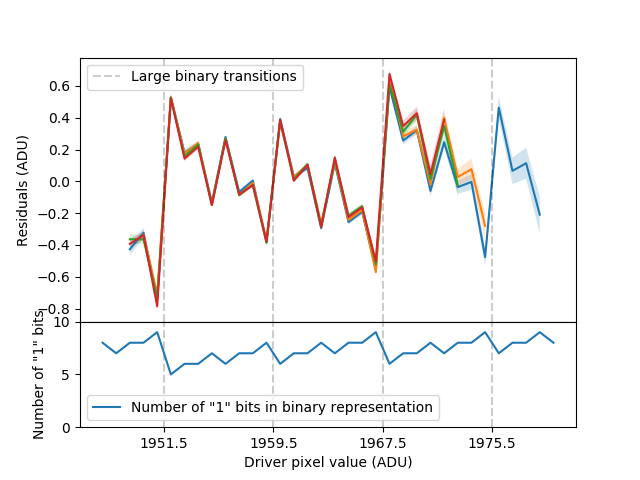

Processing ./data/snifs_r/14_016_001_002_25_R.fits
Median residual errors: 0.0213
Processing ./data/snifs_r/14_016_001_003_25_R.fits
Median residual errors: 0.0174
Processing ./data/snifs_r/14_016_001_004_25_R.fits
Median residual errors: 0.0162
Processing ./data/snifs_r/14_016_001_005_25_R.fits
Median residual errors: 0.0157


In [3]:
filenames = glob.glob('./data/snifs_r/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[0].data[:4096, :1024]
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=10)

# SNIFS B

<IPython.core.display.Javascript object>


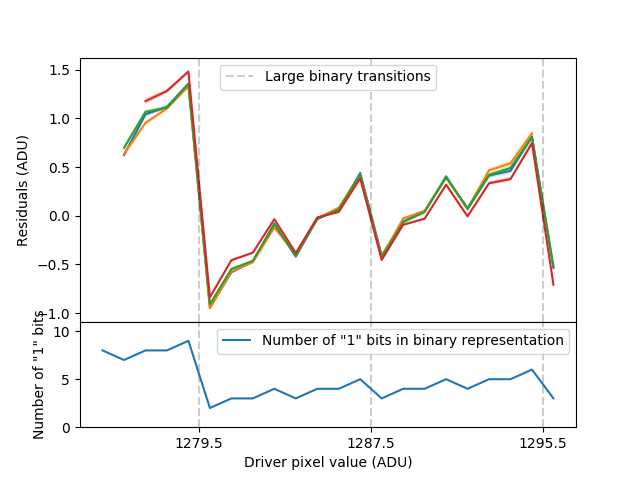

Processing ./data/snifs_b/14_004_001_001_25_B.fits
Median residual errors: 0.0146
Processing ./data/snifs_b/14_004_001_002_25_B.fits
Median residual errors: 0.0144
Processing ./data/snifs_b/14_004_001_003_25_B.fits
Median residual errors: 0.0146
Processing ./data/snifs_b/14_004_001_004_25_B.fits
Median residual errors: 0.0145


In [4]:
filenames = glob.glob('./data/snifs_b/*.fits')
fig_parts = setup_figure()

for filename in filenames:
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[1].data[:4096, 3:1027]
        plot_mean_residual(data, 2, fig_parts=fig_parts)
        
finalize_figure(fig_parts)

# CFHT Megacam

<IPython.core.display.Javascript object>


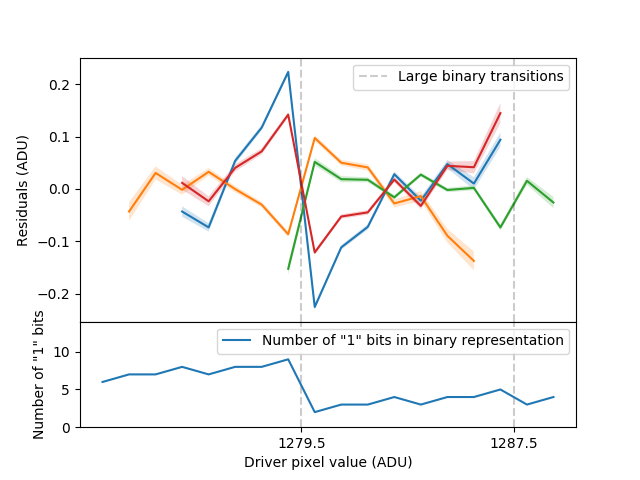

Processing index 1
Median residual errors: 0.0058
Processing index 7
Median residual errors: 0.0073
Processing index 21
Median residual errors: 0.0057
Processing index 23
Median residual errors: 0.0061


In [5]:
filename = './data/megacam/test_bias_1.fits.fz'
fig_parts = setup_figure()
#for index in range(1, 41):
for index in [1, 7, 21, 23]:
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:, :1056]
        
        # Filter for a subset of images in a region where the effect
        # is very prominent. I ran this originally and selected the
        # images with bias levels in this range to speed things up.
        if np.median(data) < 1270 or np.median(data) > 1290:
            continue
            
        print("Processing index %d" % index)

        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts, legend_loc=1, max_bits=14)

# Note: we are plotting the data from multiple amplifiers here.
# The sign and amplitude of the binary offset effect changes from
# amplifier to amplifier.

# Keck DEIMOS

<IPython.core.display.Javascript object>


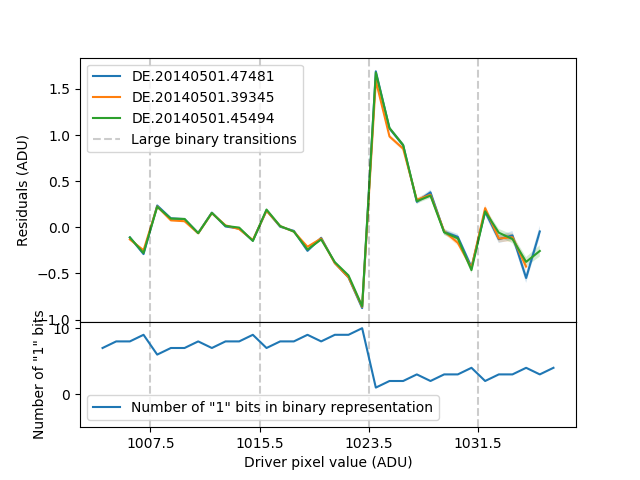

Processing ./data/deimos/DE.20140501.47481.fits.gz
Median residual errors: 0.0118
Processing ./data/deimos/DE.20140501.39345.fits.gz
Median residual errors: 0.0115
Processing ./data/deimos/DE.20140501.45494.fits.gz
Median residual errors: 0.0119


In [6]:
filenames = glob.glob('./data/deimos/*.fits.gz')
fig_parts = setup_figure()
for filename in filenames:
    index = 4
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        targ_name = filename.split('/')[-1][:-8]
        plot_mean_residual(data, 2, label=targ_name, fig_parts=fig_parts)

# plt.xlim(1000, 1040)
finalize_figure(fig_parts, show_bits=4, legend_loc=3, min_bits=-5)

plt.savefig('./binary_offset_deimos.pdf')

# Keck HIRES

<IPython.core.display.Javascript object>


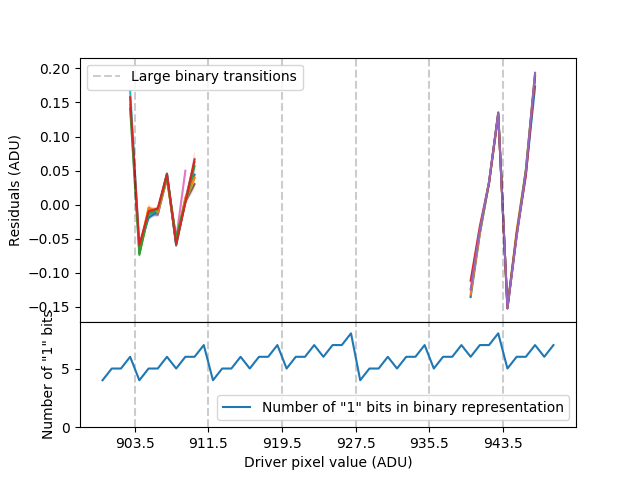

Processing ./data/keck_hires/HI.20050701.52810.fits
Median residual errors: 0.0023
Processing ./data/keck_hires/HI.20050701.52883.fits
Median residual errors: 0.0023
Processing ./data/keck_hires/HI.20050701.52956.fits
Median residual errors: 0.0021
Processing ./data/keck_hires/HI.20050701.53031.fits
Median residual errors: 0.0023
Processing ./data/keck_hires/HI.20050701.53104.fits
Median residual errors: 0.0023
Processing ./data/keck_hires/HI.20061031.15842.fits
Median residual errors: 0.0043
Processing ./data/keck_hires/HI.20061031.15879.fits
Median residual errors: 0.0042
Processing ./data/keck_hires/HI.20061031.15915.fits
Median residual errors: 0.0041
Processing ./data/keck_hires/HI.20061031.15952.fits
Median residual errors: 0.0044
Processing ./data/keck_hires/HI.20061031.15988.fits
Median residual errors: 0.0040
Processing ./data/keck_hires/HI.20061031.16025.fits
Median residual errors: 0.0044
Processing ./data/keck_hires/HI.20061031.16063.fits
Median residual errors: 0.0045
Proc

In [7]:
filenames = glob.glob('./data/keck_hires/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 3
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=9)

# Keck LRIS B

<IPython.core.display.Javascript object>


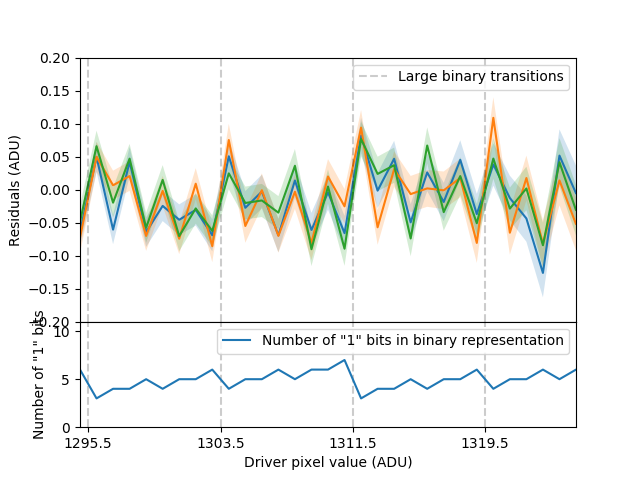

Processing ./data/lris_b/b170327_0001.fits
Median residual errors: 0.0302
Processing ./data/lris_b/b170327_0002.fits
Median residual errors: 0.0298
Processing ./data/lris_b/b170327_0003.fits
Median residual errors: 0.0300


In [8]:
filenames = glob.glob('./data/lris_b/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 3
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:2500, :]
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts, show_bits=4)

plt.xlim(1295, 1325);
fig_parts[1].set_ylim(-0.2, 0.2);

# Keck LRIS R

<IPython.core.display.Javascript object>


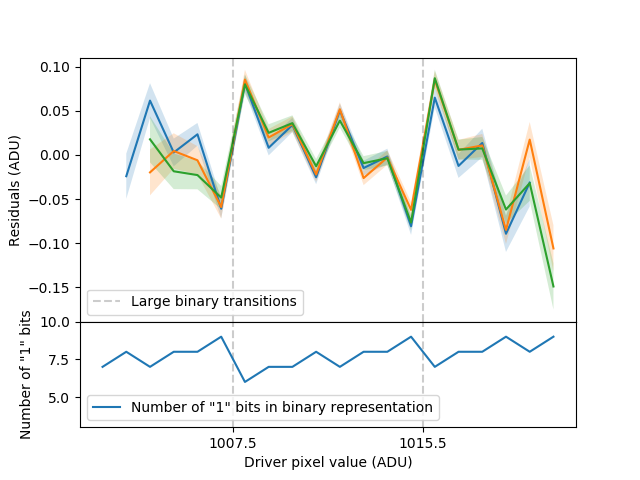

Processing ./data/lris_r/r170327_0001.fits
Median residual errors: 0.0111
Processing ./data/lris_r/r170327_0002.fits
Median residual errors: 0.0112
Processing ./data/lris_r/r170327_0003.fits
Median residual errors: 0.0112


In [9]:
filenames = glob.glob('./data/lris_r/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 1
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts, show_bits=4, min_bits=3, max_bits=10)


# SDSS

<IPython.core.display.Javascript object>


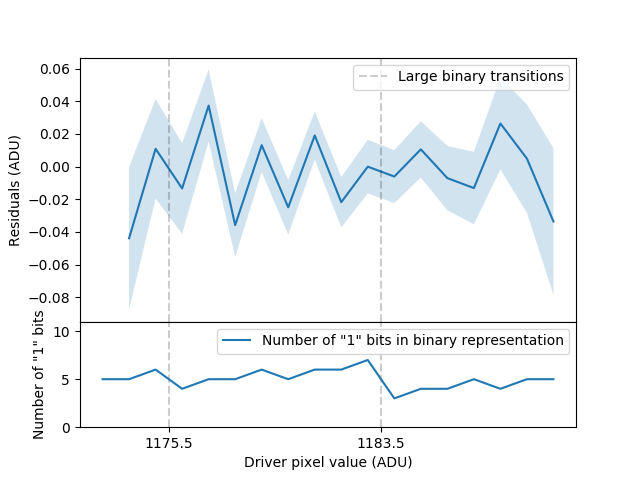

Processing ./data/sdss/idR-003459-i2-0008.fits


SDSS                           / THIS HEADER CONTAINS SPECIAL SDSS KEYWORDS      [astropy.io.fits.card]
UNSIGNED                       / UNSIGNED DATA - NO BSCALE OR BZERO KEYWORDS     [astropy.io.fits.card]


Median residual errors: 0.0197


In [10]:
filenames = glob.glob('./data/sdss/idR-003459-i2-0008.fits')
fig_parts = setup_figure()
for filename in filenames:
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[0].data[:, 70:1060]
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts)

# No evidence of the binary offset effect here... notice the scale.

# HST WFC3 UVIS

<IPython.core.display.Javascript object>


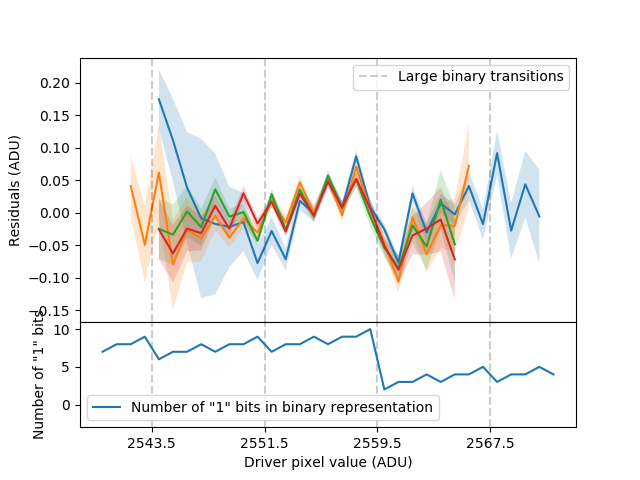

Processing ./data/hst_uvis/icn147avq_raw.fits
Median residual errors: 0.0217
Processing ./data/hst_uvis/icn148deq_raw.fits
Median residual errors: 0.0170
Processing ./data/hst_uvis/icwb1hokq_raw.fits
Median residual errors: 0.0145
Processing ./data/hst_uvis/icwb1iugq_raw.fits
Median residual errors: 0.0142


In [11]:
filenames = glob.glob('./data/hst_uvis/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 4
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:, 2110:]
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts, legend_loc=3, min_bits=-3)

# HST STIS

<IPython.core.display.Javascript object>


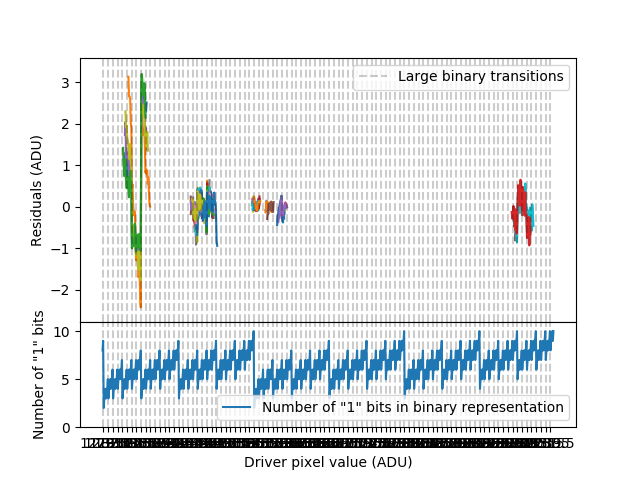

Median residual errors: 0.0799
Median residual errors: 0.0772
Median residual errors: 0.0158
Median residual errors: 0.0162
Median residual errors: 0.0156
Median residual errors: 0.0429
Median residual errors: 0.0127
Median residual errors: 0.0424
Median residual errors: 0.0096
Median residual errors: 0.0436
Median residual errors: 0.0111
Median residual errors: 0.0440
Median residual errors: 0.0110
Median residual errors: 0.0446
Median residual errors: 0.0110
Median residual errors: 0.0441
Median residual errors: 0.0120
Median residual errors: 0.0422
Median residual errors: 0.0106
Median residual errors: 0.0452
Median residual errors: 0.0091
Median residual errors: 0.0442
Median residual errors: 0.0096
Median residual errors: 0.0441
Median residual errors: 0.0101
Median residual errors: 0.0448
Median residual errors: 0.0100
Median residual errors: 0.0439
Median residual errors: 0.0088
Median residual errors: 0.0439
Median residual errors: 0.0103
Median residual errors: 0.0416
Median r

In [12]:
filenames = glob.glob('./data/hst_stis_2/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 1
    #print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts)

# Note: the amplitude varies quite a bit for the different STIS images.
# Here we show a range of different bias locations. The next image shows a zoom-in
# on the most extreme case.

<IPython.core.display.Javascript object>


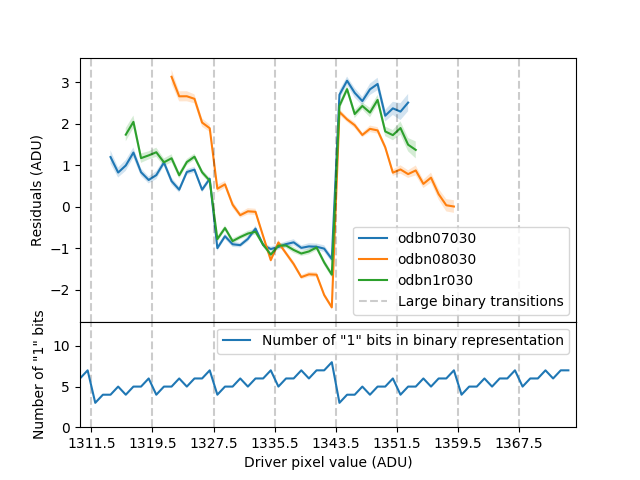

Processing ./data/hst_stis_2/odbn07030_raw.fits
Median residual errors: 0.0799
Processing ./data/hst_stis_2/odbn08030_raw.fits
Median residual errors: 0.0772
Processing ./data/hst_stis_2/odbn1r030_raw.fits
Median residual errors: 0.0749


In [13]:
filenames = glob.glob('./data/hst_stis_2/*.fits')
fig_parts = setup_figure()
num_plotted = 0
for filename in filenames:
    index = 1
    #print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        if np.median(data) > 1360 or np.median(data) < 1300:
            continue

        print("Processing", filename)
        plot_mean_residual(data, 1, label=fits_file[0].header['ROOTNAME'], fig_parts=fig_parts)
        #print(fits_file[0].header['CCDGAIN'])
        
        num_plotted += 1        
        if num_plotted >= 3:
            break

plt.xlim(1310, 1375)
            
finalize_figure(fig_parts, max_bits=13)

# Zoom in on the most extreme STIS behavior observed.

plt.savefig('./binary_offset_stis.pdf')

In [14]:
plt.savefig('./binary_offset_stis.pdf')

# HST ACS

<IPython.core.display.Javascript object>


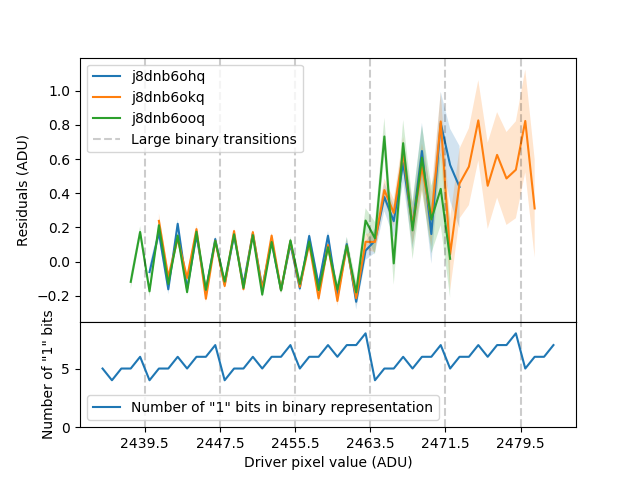

Processing ./data/hst_acs/j8dnb6ohq_raw.fits
Median residual errors: 0.0287
Processing ./data/hst_acs/j8dnb6okq_raw.fits


/home/kboone/packages/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Median residual errors: nan
Processing ./data/hst_acs/j8dnb6ooq_raw.fits
Median residual errors: 0.0308


In [15]:
filenames = glob.glob('./data/hst_acs/*.fits')
fig_parts = setup_figure()
for filename in filenames[:3]:
    index = 1
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:, :2048]
        plot_mean_residual(data, 1, label=fits_file[0].header['ROOTNAME'], fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=9)

# ACS behaves very strangely. We find oscillating residuals that seem
# to only depend on the 0th bit. However, at the binary transition
# at 2463-2464 there is a large step in the residuals.

plt.savefig('./binary_offset_hst_acs.pdf')

# VLT FORS 1

<IPython.core.display.Javascript object>


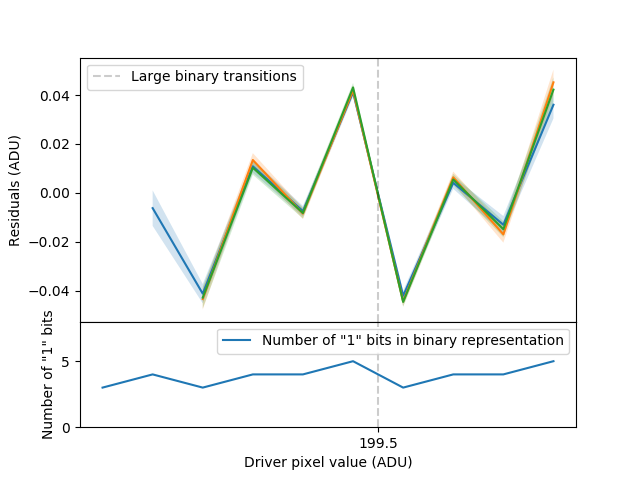

Processing ./data/vlt_fors_1/FORS1.2008-11-15T08-16-02.550.fits
Median residual errors: 0.0027
Processing ./data/vlt_fors_1/FORS1.2008-11-15T08-17-00.945.fits
Median residual errors: 0.0026
Processing ./data/vlt_fors_1/FORS1.2008-11-15T08-17-58.961.fits
Median residual errors: 0.0026


In [16]:
filenames = glob.glob('./data/vlt_fors_1/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 0
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data.T
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=8, show_bits=4)

# VLT FORS 2

<IPython.core.display.Javascript object>


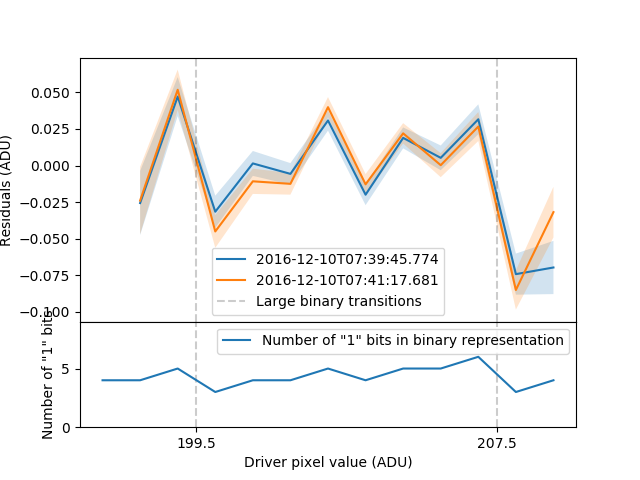

Processing ./data/vlt_fors_2/FORS2.2016-12-10T07-39-45.644.fits
Median residual errors: 0.0094
Processing ./data/vlt_fors_2/FORS2.2016-12-10T07-41-17.662.fits
Median residual errors: 0.0093


In [17]:
filenames = glob.glob('./data/vlt_fors_2/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 0
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data.T
        plot_mean_residual(data, 1, label=fits_file[0].header['DATE'], fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=9)

# VLT MUSE

<IPython.core.display.Javascript object>


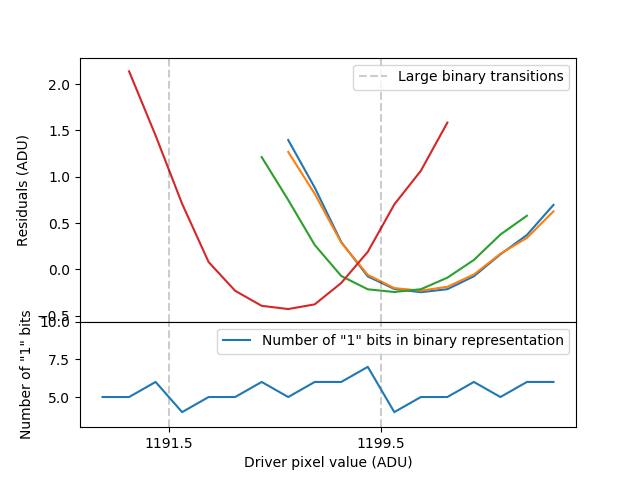

Processing ./data/vlt_muse/MUSE.2014-11-04T10-04-45.079.fits.fz
Median residual errors: 0.0064
Processing ./data/vlt_muse/MUSE.2015-04-04T10-34-50.858.fits.fz
Median residual errors: 0.0063
Processing ./data/vlt_muse/MUSE.2015-05-24T10-56-24.609.fits.fz
Median residual errors: 0.0065
Processing ./data/vlt_muse/MUSE.2015-10-14T10-09-08.142.fits.fz
Median residual errors: 0.0081


In [18]:
filenames = glob.glob('./data/vlt_muse/*.fits.fz')
fig_parts = setup_figure()
for filename in filenames:
    index = 3
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:2100, :2100]
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts, min_bits=3, max_bits=10)

# No evidence of the binary offset effect, residuals are smooth. The slope
# here is probably due to some other form of directed correlations between
# pixels.

# Kepler

<IPython.core.display.Javascript object>


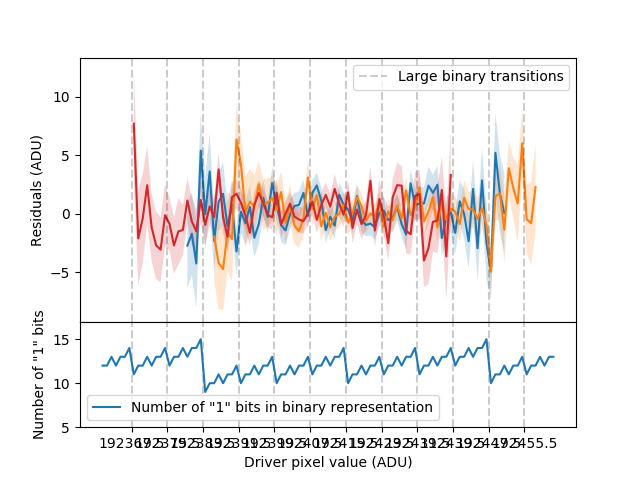

Processing ./data/kepler/kplr2012277203051_ffi-orig.fits


/home/kboone/packages/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Median residual errors: nan
Processing ./data/kepler/kplr2011208112727_ffi-orig.fits


/home/kboone/packages/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Median residual errors: nan
Processing ./data/kepler/kplr2011240181752_ffi-orig.fits


/home/kboone/packages/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Median residual errors: nan
Processing ./data/kepler/kplr2011271191331_ffi-orig.fits


/home/kboone/packages/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Median residual errors: nan


In [19]:
filenames = glob.glob('./data/kepler/*.fits')
fig_parts = setup_figure()
for filename in filenames:
#filename = filenames[0]
#for index in range(1, 81):
    index = 53
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:, 1110:]
        #print(index, nmad(data))
        plot_mean_residual(data, 3, fig_parts=fig_parts)

finalize_figure(fig_parts, min_bits=5, max_bits=17)

# I was unable to find a bias or flat image for Kepler. Instead, I'm
# just looking at the overscan region on the edge of some of the FFI
# images. Unfortunately this region is too small and noisy to really
# say anything meaningful.

# Gemini GMOS-S Hamamatsu (post 2014)

<IPython.core.display.Javascript object>


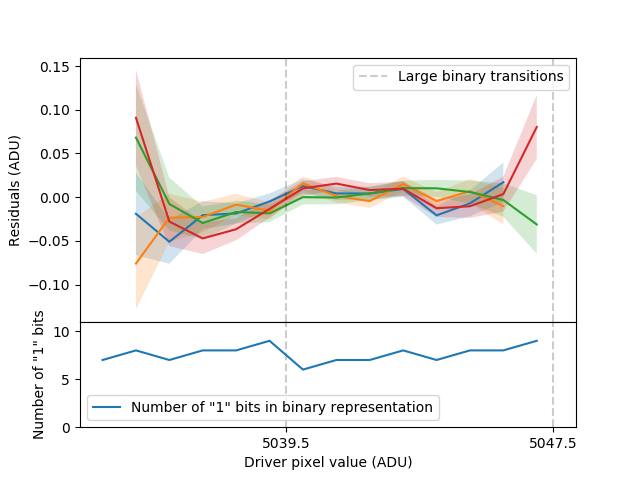

Processing ./data/gemini_gmos_s_hamamatsu/S20170725S0276.fits
Median residual errors: 0.0111
Processing ./data/gemini_gmos_s_hamamatsu/S20170725S0277.fits
Median residual errors: 0.0112
Processing ./data/gemini_gmos_s_hamamatsu/S20170725S0278.fits
Median residual errors: 0.0130
Processing ./data/gemini_gmos_s_hamamatsu/S20170725S0279.fits
Median residual errors: 0.0126


In [20]:
filenames = glob.glob('./data/gemini_gmos_s_hamamatsu/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 3
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts)

# No effect seen

# Gemini GMOS-S E2V (pre 2014)

<IPython.core.display.Javascript object>


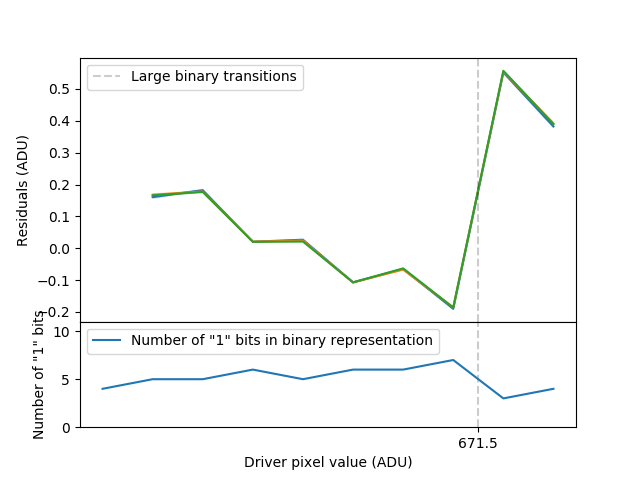

Processing ./data/gemini_gmos_s_e2v/S20100101S0160.fits
Median residual errors: 0.0024
Processing ./data/gemini_gmos_s_e2v/S20100101S0161.fits
Median residual errors: 0.0025
Processing ./data/gemini_gmos_s_e2v/S20100101S0162.fits
Median residual errors: 0.0025


In [21]:
filenames = glob.glob('./data/gemini_gmos_s_e2v/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 2
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts)

# Gemini GMOS-N Hamamatsu (post 2017)

<IPython.core.display.Javascript object>


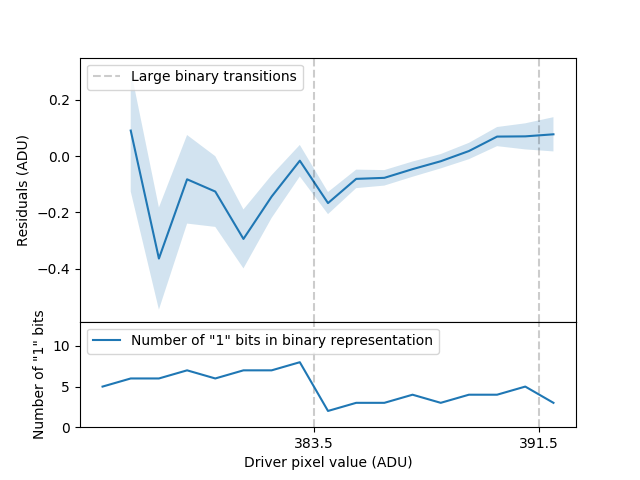

Processing ./data/gemini_gmos_n_hamamatsu/N20170707S0607.fits
Median residual errors: 0.0512


In [22]:
filenames = glob.glob('./data/gemini_gmos_n_hamamatsu/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 6
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[120:, 20:]
        plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts, max_bits=13)

# No effect seen

# Gemini GMOS-N E2V (pre 2017)

<IPython.core.display.Javascript object>


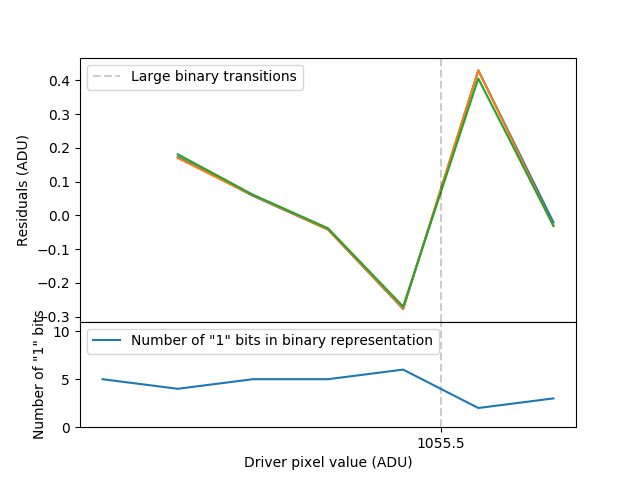

Processing ./data/gemini_gmos_n_e2v/N20150107S0397.fits
Median residual errors: 0.0023
Processing ./data/gemini_gmos_n_e2v/N20150107S0398.fits
Median residual errors: 0.0024
Processing ./data/gemini_gmos_n_e2v/N20150107S0399.fits
Median residual errors: 0.0023


In [23]:
filenames = glob.glob('./data/gemini_gmos_n_e2v/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 2
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts)

# Blanco DECam

/home/kboone/packages/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


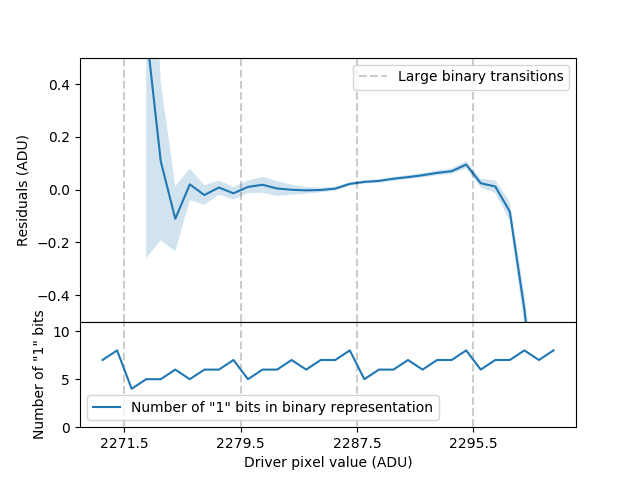

Processing ./data/blanco_decam/dec009765.fits.fz


/home/kboone/packages/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


Median residual errors: nan


(-0.5, 0.5)

In [24]:
filenames = glob.glob('./data/blanco_decam/dec009765.fits.fz')
fig_parts = setup_figure()
for filename in filenames:
    index = 2
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        data = fits_file[index].data[:, 1024:]
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts)

fig_parts[1].set_ylim(-0.5, 0.5)

# No effect seen

# Subaru Hyper Suprime-Cam

/home/kboone/packages/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


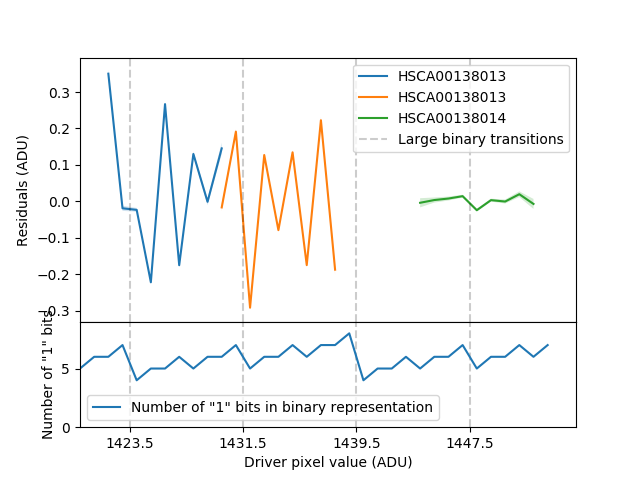

Processing ./data/subaru_hsc/HSCA00138012.fits
Processing ./data/subaru_hsc/HSCA00138013.fits
Median residual errors: 0.0066
Median residual errors: 0.0064
Processing ./data/subaru_hsc/HSCA00138014.fits
Median residual errors: 0.0054


In [25]:
filenames = sorted(glob.glob('./data/subaru_hsc/*.fits'))
fig_parts = setup_figure()
for filename in filenames:
    index = 0
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        for chip_section in range(4):
            # print("Chip %d" % chip_section)
            data = fits_file[index].data[:, chip_section*536+20:(chip_section+1)*536-20]
            
            # Cut to a representative sample for display purposes.
            if np.median(data) > 1455 or np.median(data) < 1420:
                continue
                
            plot_mean_residual(data, 1, label=fits_file[0].header['FRAMEID'], fig_parts=fig_parts)

finalize_figure(fig_parts, show_bits=4, max_bits=9)

plt.xlim(1420, 1455)

# The residuals are definitely correlated with the LSB here. There doesn't seem
# to be a trend with the higher bits though. I zoomed in on a selection of images.
# Zoom out to see more.

plt.savefig('./binary_offset_subaru_hsc.pdf')

In [26]:
plt.savefig('./binary_offset_subaru_hsc.pdf')

# Subaru Suprime-Cam

/home/kboone/packages/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


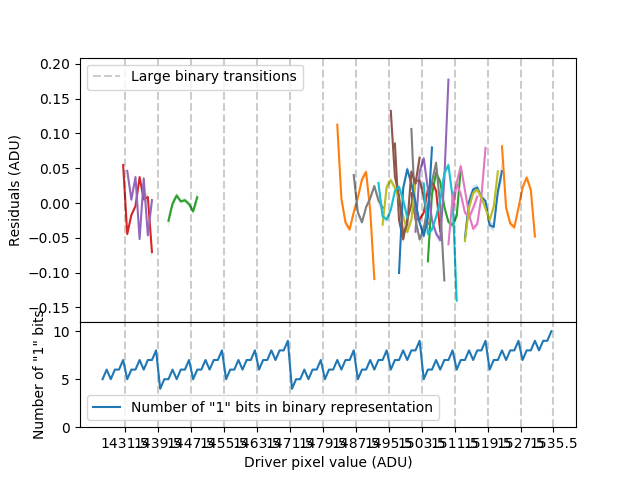

Processing ./data/subaru_sc/SUPA01530653.fits
Median residual errors: 0.0061
Median residual errors: 0.0057
Median residual errors: 0.0058
Median residual errors: 0.0048
Processing ./data/subaru_sc/SUPA01530654.fits
Median residual errors: 0.0057
Median residual errors: 0.0064
Median residual errors: 0.0058
Median residual errors: 0.0055
Processing ./data/subaru_sc/SUPA01530655.fits
Median residual errors: 0.0055
Median residual errors: 0.0059
Median residual errors: 0.0051
Median residual errors: 0.0060
Processing ./data/subaru_sc/SUPA01530656.fits
Median residual errors: 0.0046
Median residual errors: 0.0044
Median residual errors: 0.0045
Median residual errors: 0.0046
Processing ./data/subaru_sc/SUPA01530657.fits
Median residual errors: 0.0049
Median residual errors: 0.0047
Median residual errors: 0.0047
Median residual errors: 0.0052


In [27]:
filenames = glob.glob('./data/subaru_sc/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 0
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        for chip_section in range(4):
            data = fits_file[index].data[:, chip_section*568:(chip_section+1)*568]
            plot_mean_residual(data, 1, fig_parts=fig_parts)

finalize_figure(fig_parts)

# There is some interesting structure in the residuals, but it is smoothly
# varying. This is not the binary offset effect.

# Subaru Focas

/home/kboone/packages/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


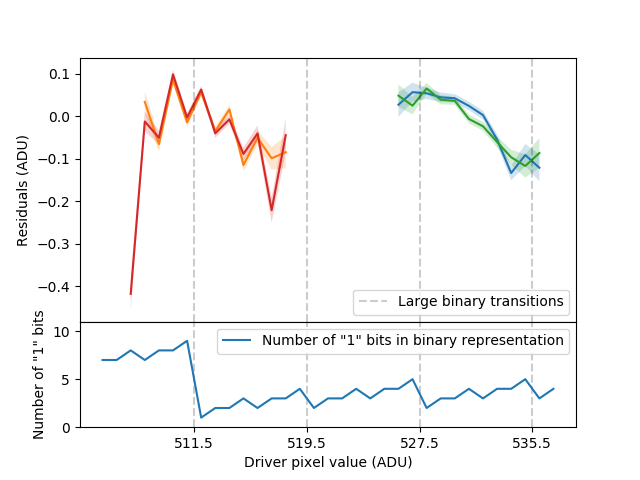

Processing ./data/subaru_focas/FCSA00163297.fits
Median residual errors: 0.0134
Processing ./data/subaru_focas/FCSA00163298.fits
Median residual errors: 0.0139
Processing ./data/subaru_focas/FCSA00163299.fits
Median residual errors: 0.0130
Processing ./data/subaru_focas/FCSA00163300.fits
Median residual errors: 0.0157


In [28]:
filenames = glob.glob('./data/subaru_focas/*.fits')
fig_parts = setup_figure()
for filename in filenames:
    index = 0
    print("Processing", filename)
    with fits.open(filename) as fits_file:
        chip_section = 0
        #for chip_section in range(4):
        data = fits_file[index].data[:, chip_section*276:(chip_section+1)*276]
        plot_mean_residual(data, 2, fig_parts=fig_parts)

finalize_figure(fig_parts)

# Evidence of an effect based on the LSB. However, it is not always
# present.

# WHT OASIS

/home/kboone/packages/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


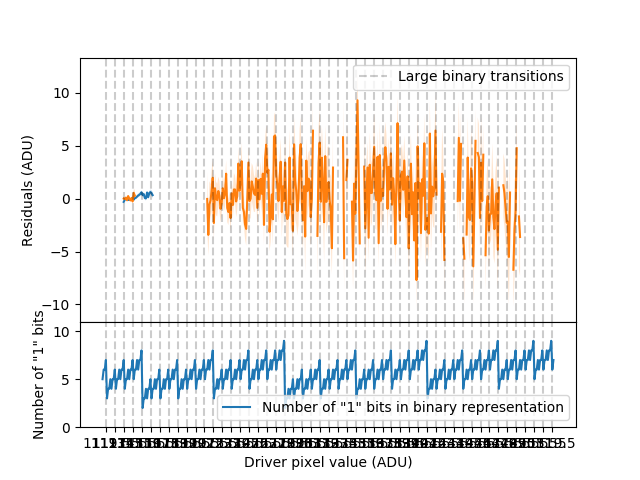

Median residual errors: 0.1786
Median residual errors: nan


/home/kboone/packages/conda/lib/python3.5/site-packages/numpy/lib/function_base.py:3569: RuntimeWarning: Invalid value encountered in median
  RuntimeWarning)


In [29]:
filenames = glob.glob('./data/wht_oasis/*.fits')
file_06 = fits.open('./data/wht_oasis/471086t.fits')
file_120 = fits.open('./data/wht_oasis/471197t.fits')
file_300 = fits.open('./data/wht_oasis/471230t.fits')

data_06 = file_06[0].data
data_120 = file_120[0].data
data_300 = file_300[0].data

sub_06 = data_06 - np.median(data_06[:, -40:])
sub_120 = data_120 - np.median(data_120[:, -40:])
sub_300 = data_300 - np.median(data_300[:, -40:])

# These aren't very clean...


residuals_06 = sub_06 - sub_300 * 0.6 / 300
residuals_120 = sub_120 - sub_300 * 120 / 300

fig_parts = setup_figure()
plot_mean_residual(data_06, 1, residuals=residuals_06, fig_parts=fig_parts)
plot_mean_residual(data_120, 1, residuals=residuals_120, fig_parts=fig_parts)

finalize_figure(fig_parts)

# Nothing obvious going on.

# Subaru HSC advanced tests

In [30]:
filename = './data/subaru_hsc/HSCA00138013.fits'

with fits.open(filename) as fits_file:
    data = fits_file[0].data[:, 20:516]

sub_data = subtract_background(data.astype(float).copy())

/home/kboone/packages/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


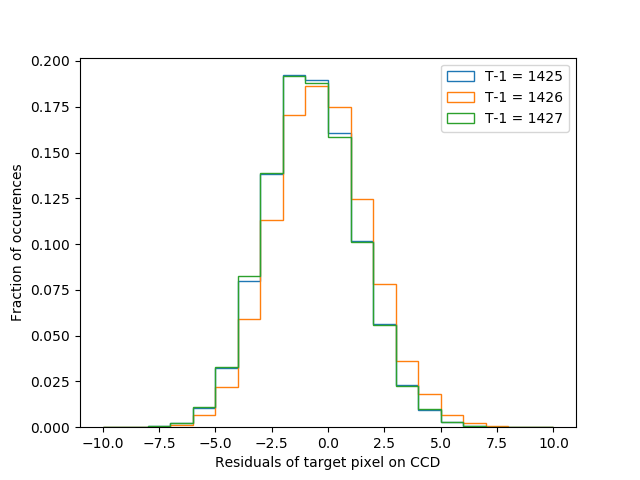

In [31]:
# Is there is a real difference for HSC between two adjacent pixel values?
# 1425 and 1427 have the same distribution of residuals, but 1426 is very
# different.
plt.figure();

plt.hist(sub_data[np.roll(data, 1) == 1425], 20, range=(-10, 10), edgecolor='C0', fill=False, label='T-1 = 1425', histtype='step', normed=True);
plt.hist(sub_data[np.roll(data, 1) == 1426], 20, range=(-10, 10), edgecolor='C1', fill=False, label='T-1 = 1426', histtype='step', normed=True);
plt.hist(sub_data[np.roll(data, 1) == 1427], 20, range=(-10, 10), edgecolor='C2', fill=False, label='T-1 = 1427', histtype='step', normed=True);

plt.xlabel('Residuals of target pixel on CCD')
plt.ylabel('Fraction of occurences')
plt.legend()

/home/kboone/packages/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<IPython.core.display.Javascript object>


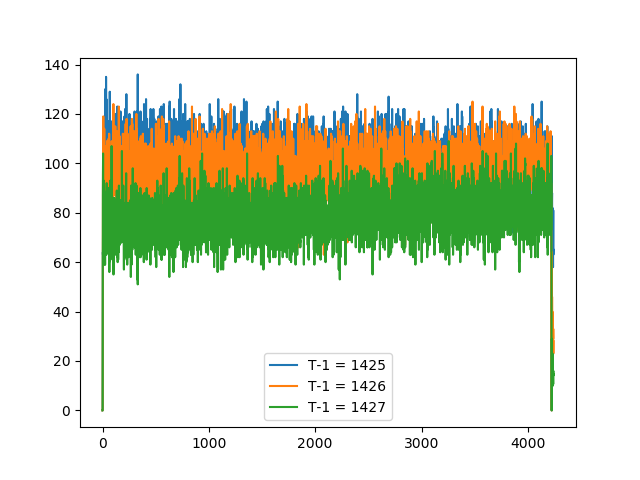

In [32]:
# Do specific values appear more often on a specific row or column?
# No evidence that this is the case.
plt.figure()
for i in [1425, 1426, 1427]:
    plt.plot(np.sum((np.roll(data, 1) == i), axis=1), label='T-1 = %d' % i)
    
plt.legend()